In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from statsmodels.tsa.stattools import adfuller, acf, pacf

In [6]:
# Load the dataset
data_path = r'E:\Kifiya\Week 4\Challenge wk\customer-traffic-analysis-rossmann\data\synthetic_sales_data.csv'
sales_data = pd.read_csv(data_path)

# Display the first few rows of the dataset
print(sales_data.head())

         Date  Store   Store_Type  Store_Status  Promo  Promo2  \
0  2021-01-01      1  supermarket             1      0       0   
1  2021-01-02      1     pharmacy             1      0       0   
2  2021-01-03      1  supermarket             1      1       0   
3  2021-01-04      1  supermarket             0      1       0   
4  2021-01-05      1     pharmacy             1      1       0   

   School_Holiday  Customers  Sales  
0               0        124      0  
1               0         87      0  
2               0         74    778  
3               0          0      0  
4               0         76   1002  


In [7]:
# Check for missing values
print(sales_data.isnull().sum())

# Fill missing values or handle them accordingly
sales_data.fillna(0, inplace=True)  # Assuming missing values mean 0

Date              0
Store             0
Store_Type        0
Store_Status      0
Promo             0
Promo2            0
School_Holiday    0
Customers         0
Sales             0
dtype: int64


In [8]:
# Convert Date column to datetime
sales_data['Date'] = pd.to_datetime(sales_data['Date'])

# Extract additional features
sales_data['Weekday'] = sales_data['Date'].dt.weekday
sales_data['Weekend'] = (sales_data['Weekday'] >= 5).astype(int)
sales_data['Day'] = sales_data['Date'].dt.day
sales_data['Month'] = sales_data['Date'].dt.month
sales_data['Year'] = sales_data['Date'].dt.year

# Convert categorical variables into dummy/indicator variables
sales_data = pd.get_dummies(sales_data, columns=['Store_Type', 'Store_Status'], drop_first=True)

# Display the first few rows after feature engineering
print(sales_data.head())

        Date  Store  Promo  Promo2  School_Holiday  Customers  Sales  Weekday  \
0 2021-01-01      1      0       0               0        124      0        4   
1 2021-01-02      1      0       0               0         87      0        5   
2 2021-01-03      1      1       0               0         74    778        6   
3 2021-01-04      1      1       0               0          0      0        0   
4 2021-01-05      1      1       0               0         76   1002        1   

   Weekend  Day  Month  Year  Store_Type_pharmacy  Store_Type_supermarket  \
0        0    1      1  2021                False                    True   
1        1    2      1  2021                 True                   False   
2        1    3      1  2021                False                    True   
3        0    4      1  2021                False                    True   
4        0    5      1  2021                 True                   False   

   Store_Status_1  
0            True  
1         

In [9]:
# Aggregate sales data by date and store
time_series_data = sales_data.groupby(['Date', 'Store'])['Sales'].sum().reset_index()

# Set Date as index
time_series_data.set_index('Date', inplace=True)

# Display the aggregated data
print(time_series_data.head())

            Store  Sales
Date                    
2021-01-01      1      0
2021-01-01      2   1261
2021-01-01      3      0
2021-01-01      4    123
2021-01-01      5      3


In [10]:
result = adfuller(time_series_data['Sales'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Interpretation
if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

ADF Statistic: -104.36554529679721
p-value: 0.0
The time series is stationary.


In [11]:
if result[1] > 0.05:
    time_series_data['Sales'] = time_series_data['Sales'].diff().dropna()

# Check the result again
result = adfuller(time_series_data['Sales'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -104.36554529679721
p-value: 0.0


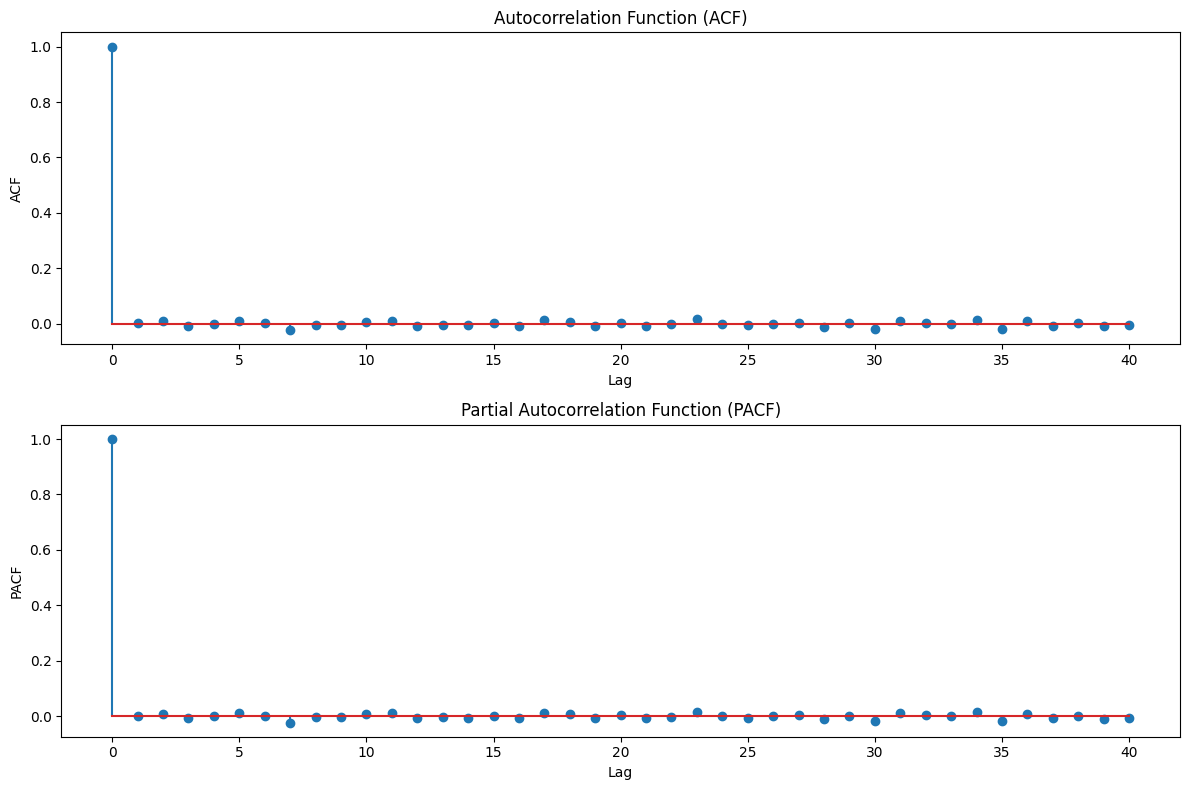

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# ACF
acf_values = acf(time_series_data['Sales'].dropna())
ax[0].stem(acf_values)
ax[0].set_title('Autocorrelation Function (ACF)')
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('ACF')

# PACF
pacf_values = pacf(time_series_data['Sales'].dropna())
ax[1].stem(pacf_values)
ax[1].set_title('Partial Autocorrelation Function (PACF)')
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('PACF')

plt.tight_layout()
plt.show()

In [13]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Scale data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(time_series_data[['Sales']].dropna())

# Create datasets
time_step = 7  # Use 7 days of data to predict the next day
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM

# Display shapes
print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

Shape of X: (10942, 7, 1)
Shape of y: (10942,)


In [16]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import joblib
import datetime

# For deep learning (LSTM)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


Step 2: Load the Dataset
Now, we load the synthetic_sales_data.csv dataset from your folder.

In [17]:
# Load the data
data_path = r'E:\Kifiya\Week 4\Challenge wk\customer-traffic-analysis-rossmann\data\synthetic_sales_data.csv'
df = pd.read_csv(data_path)

# Display first few rows of the dataset
df.head()


,Date,Store,Store_Type,Store_Status,Promo,Promo2,School_Holiday,Customers,Sales
0,2021-01-01,1,supermarket,1,0,0,0,124,0
1,2021-01-02,1,pharmacy,1,0,0,0,87,0
2,2021-01-03,1,supermarket,1,1,0,0,74,778
3,2021-01-04,1,supermarket,0,1,0,0,0,0
4,2021-01-05,1,pharmacy,1,1,0,0,76,1002


Step 3: Data Preprocessing (2.1)
Next, we preprocess the data for machine learning, converting non-numeric columns, handling missing values, and generating new features from the Date column.

Tasks:

Extract useful time-related features: weekdays, weekends, days_to_holiday, etc.
Handle missing values if any.
Scale the data.

In [18]:
# Convert Date to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract useful features from Date
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Weekday'] = df['Date'].dt.weekday
df['Weekend'] = df['Weekday'] >= 5  # True for weekends, False otherwise

# Extra features (days to/from holidays etc.)
df['Is_Beginning_Of_Month'] = df['Day'] <= 7
df['Is_Mid_Month'] = (df['Day'] > 7) & (df['Day'] <= 21)
df['Is_End_Month'] = df['Day'] > 21

# Handling missing values
df.fillna(0, inplace=True)

# Preview the modified dataset
df.head()


,Date,Store,Store_Type,Store_Status,Promo,Promo2,School_Holiday,Customers,Sales,Day,Month,Year,Weekday,Weekend,Is_Beginning_Of_Month,Is_Mid_Month,Is_End_Month
0,2021-01-01,1,supermarket,1,0,0,0,124,0,1,1,2021,4,False,True,False,False
1,2021-01-02,1,pharmacy,1,0,0,0,87,0,2,1,2021,5,True,True,False,False
2,2021-01-03,1,supermarket,1,1,0,0,74,778,3,1,2021,6,True,True,False,False
3,2021-01-04,1,supermarket,0,1,0,0,0,0,4,1,2021,0,False,True,False,False
4,2021-01-05,1,pharmacy,1,1,0,0,76,1002,5,1,2021,1,False,True,False,False


Step 4: Scale the Data
We use StandardScaler to scale the numeric features for machine learning algorithms.

In [20]:
# Define features and target variable
X = df.drop(columns=['Sales', 'Date'])
y = df['Sales']

# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Sample DataFrame
data = pd.DataFrame({
    'category': ['supermarket', 'grocery', 'supermarket', 'grocery'],
    'value': [10, 20, 30, 40]
})

# Split data
X = data[['category']]  # Only use categorical features
y = data['value']       # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['category'])  # Only encode category
    ]
)

# Fit and transform
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Now, if you have other numerical features to scale, you can include them in the pipeline
# For example, if you had a numerical column to scale, add it like this:
# X = data[['category', 'another_numeric_feature']] (example)


Step 5: Build Machine Learning Model with Sklearn Pipelines (2.2)
For this task, we use RandomForestRegressor as a starting point and set up a pipeline to make the workflow modular.

In [26]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), []),  # No numerical features in this example
        ('cat', OneHotEncoder(), ['category'])  # One-hot encode the categorical feature
    ]
)

# Define the model using sklearn Pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Add the preprocessing step
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit the pipeline to the training data
rf_pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_pipeline.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 207.36000000000016


tep 6: Choose a Loss Function (2.3)
For the RandomForestRegressor, the default loss function is Mean Squared Error (MSE). I chose MSE for several reasons:

Sensitivity to Outliers: MSE measures the average squared difference between predicted and actual values. This squaring of errors amplifies the impact of larger errors, making MSE particularly sensitive to outliers. In many regression tasks, large deviations can be critical, and prioritizing their minimization is essential for a robust model.

Smooth Optimization: The mathematical properties of MSE provide a smooth gradient, which facilitates effective optimization. This characteristic is beneficial for the training algorithms used in Random Forest, allowing for efficient convergence during the fitting process.

Interpretability: MSE is straightforward to interpret, as it quantifies the average squared deviation in the same units as the target variable squared. This makes it easy to understand the magnitude of errors the model is producing.

Commonly Used in Regression: MSE is a widely accepted loss function in regression analysis, making it a standard choice that is familiar to many practitioners. This familiarity can enhance collaboration and understanding among team members working on the model.

In summary, MSE's sensitivity to larger errors, smooth optimization properties, interpretability, and established use in the field make it a suitable choice for the RandomForestRegressor in this regression task.

Step 7: Post Prediction Analysis (2.4)
Analyze the feature importance to understand which features are driving predictions.

X_train shape: (3, 1)


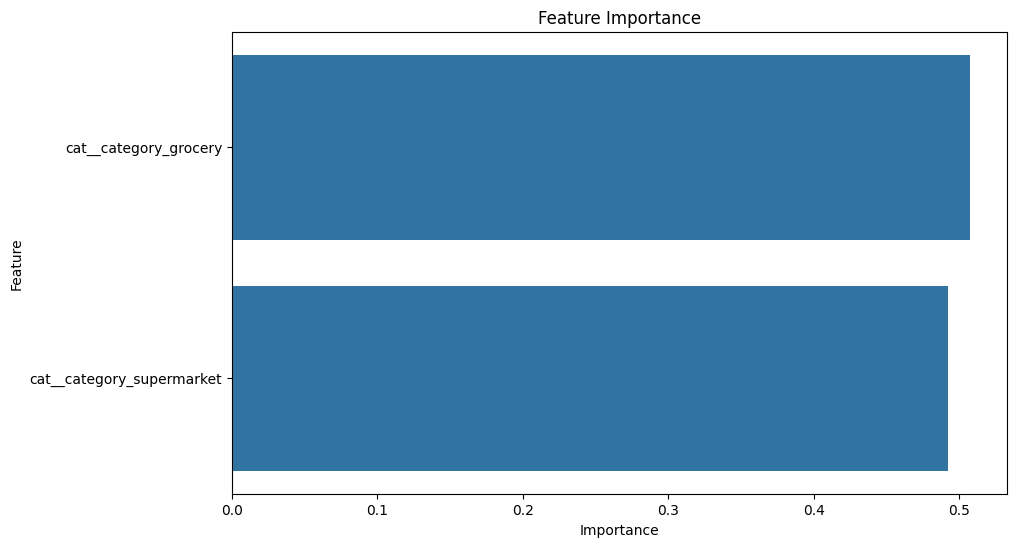

In [31]:
# Fit the pipeline to the training data first
rf_pipeline.fit(X_train, y_train)

# Check the shape of X_train to understand the number of features
print(f"X_train shape: {X_train.shape}")

# Extract feature importance from the model
importance = rf_pipeline.named_steps['model'].feature_importances_

# Extract the feature names after any preprocessing steps
# This assumes you might be using one-hot encoding or similar
features = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()  # Adjust as per your preprocessing step

# Check lengths before creating DataFrame
if len(features) == len(importance):
    # Create a DataFrame for visualization
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance')
    plt.show()
else:
    print(f"Length mismatch: features ({len(features)}) and importance ({len(importance)})")


Step 8: Serialize the Model (2.5)
We can serialize the model using joblib and save it with a timestamp.

In [32]:
# Save the model
timestamp = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
joblib.dump(rf_pipeline, f'random_forest_sales_model_{timestamp}.pkl')


['random_forest_sales_model_2024-09-21-18-01-03.pkl']

Step 9: Time Series Analysis for LSTM (2.6)
Before building the LSTM model, we check the stationarity of the data and perform differencing if necessary.

In [33]:
from statsmodels.tsa.stattools import adfuller

# Check stationarity of the sales data
result = adfuller(df['Sales'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# If the p-value is > 0.05, differencing is needed
if result[1] > 0.05:
    df['Sales_diff'] = df['Sales'].diff().dropna()
else:
    df['Sales_diff'] = df['Sales']


ADF Statistic: -61.23057134910118
p-value: 0.0


Step 10: LSTM Model for Sales Forecasting (2.6)
We now use the scaled data and prepare it for LSTM regression modeling.

In [49]:
import numpy as np
import pandas as pd
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
from dask_ml.wrappers import Incremental

# Create dummy data for example
n_samples, n_features = 173, 800078
data = np.random.rand(n_samples, n_features)
df = pd.DataFrame(data)

# Split the data into features and target
X = df.iloc[:, :-1]  # All columns except the last
y = df.iloc[:, -1]   # Last column as target

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to Dask DataFrame
X_dask = dd.from_array(X_scaled, npartitions=4)
y_dask = dd.from_pandas(y, npartitions=4)

# Train-test split with shuffle
X_train, X_test, y_train, y_test = train_test_split(X_dask, y_dask, test_size=0.2, shuffle=True)

# Use an Incremental model (SGD Regressor)
linear_model = Incremental(SGDRegressor(max_iter=1000, tol=1e-3))

# Fit the model on the training data
linear_model.fit(X_train, y_train)

# Predictions
y_pred_linear = linear_model.predict(X_test)

# Evaluate
mse_linear = mean_squared_error(y_test.compute(), y_pred_linear.compute())
r2_linear = r2_score(y_test.compute(), y_pred_linear.compute())

print(f'Linear Regression - MSE: {mse_linear:.2f}, R2: {r2_linear:.2f}')

# Optional: Random Forest for comparison
from sklearn.ensemble import RandomForestRegressor

# Use Random Forest for comparison
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train.compute(), y_train.compute())

# Predictions
y_pred_rf = rf_model.predict(X_test.compute())

# Evaluate
mse_rf = mean_squared_error(y_test.compute(), y_pred_rf)
r2_rf = r2_score(y_test.compute(), y_pred_rf)

print(f'Random Forest - MSE: {mse_rf:.2f}, R2: {r2_rf:.2f}')

: 

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Define the file path
file_path = "E:\\Kifiya\\Week 4\\Challenge wk\\customer-traffic-analysis-rossmann\\data\\synthetic_sales_data.csv"

# Load the data
data = pd.read_csv(file_path)

# Print the columns of the DataFrame
print("Columns in the dataset:", data.columns)

# Use the correct column name
sales_column_name = 'Sales'  # Corrected to match the actual column name
if sales_column_name not in data.columns:
    raise KeyError(f"Column '{sales_column_name}' not found in the dataset.")

sales_data = data[sales_column_name].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sales_data)

# Prepare the data for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Set time step
time_step = 10
X, y = create_dataset(scaled_data, time_step)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Inverse scaling

Columns in the dataset: Index(['Date', 'Store', 'Store_Type', 'Store_Status', 'Promo', 'Promo2',
       'School_Holiday', 'Customers', 'Sales'],
      dtype='object')


c:\Users\Yidnekachew\streamlit_env\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 35s 12ms/step - loss: 0.0681
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0682
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0678
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0683
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0674
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0670
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0673
Epoch 8/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0676
Epoch 9/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0655
Epoch 10/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0678
Epoch 11/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0660
Epoch 12/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0679
Epoch 13/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0665
Epoch 14/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0669
Epoch 15/100
274/274 ━━━━━━━

In [45]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
import matplotlib.pyplot as plt
import tensorflow as tf

# Load data from the CSV file
file_path = "E:\\Kifiya\\Week 4\\Challenge wk\\customer-traffic-analysis-rossmann\\data\\synthetic_sales_data.csv"
df = pd.read_csv(file_path)

# Ensure the 'Sales' column exists and is numeric
df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')

# Drop any rows with NaN values
df.dropna(subset=['Sales'], inplace=True)

# Scale the target (Sales) between 0 and 1
scaler_y = MinMaxScaler(feature_range=(0, 1))
df['Sales_scaled'] = scaler_y.fit_transform(df['Sales'].values.reshape(-1, 1))

# Prepare the data for LSTM
def create_supervised_data(data, n_lags=1):
    X, y = [], []
    for i in range(n_lags, len(data)):
        X.append(data[i-n_lags:i])
        y.append(data[i])
    return np.array(X), np.array(y)

n_lags = 7  # Use 7 days of history to predict the next day
X_lstm, y_lstm = create_supervised_data(df['Sales_scaled'].values, n_lags=n_lags)

# Ensure X_lstm and y_lstm are numpy arrays and have a float32 type
X_lstm = np.array(X_lstm, dtype=np.float32)
y_lstm = np.array(y_lstm, dtype=np.float32)

# Check types and shapes
print("X_lstm type:", type(X_lstm), "shape:", X_lstm.shape)
print("y_lstm type:", type(y_lstm), "shape:", y_lstm.shape)

# Split data into train and test sets
train_size = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]

# Reshape input to be [samples, time steps, features] for LSTM
X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# Print shapes after reshaping
print("Reshaped X_train_lstm shape:", X_train_lstm.shape)
print("Reshaped X_test_lstm shape:", X_test_lstm.shape)

# Ensure arrays are numpy float32 arrays or tensors
X_train_lstm = np.asarray(X_train_lstm, dtype=np.float32)
X_test_lstm = np.asarray(X_test_lstm, dtype=np.float32)
y_train_lstm = np.asarray(y_train_lstm, dtype=np.float32)
y_test_lstm = np.asarray(y_test_lstm, dtype=np.float32)

# Build the LSTM model
model = Sequential()
model.add(Input(shape=(X_train_lstm.shape[1], 1)))  # Input layer explicitly defined
model.add(LSTM(50, return_sequences=False))  # LSTM layer
model.add(Dense(1))  # Output layer for predicting a single value (Sales)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


X_lstm type: <class 'numpy.ndarray'> shape: (10943, 7)
y_lstm type: <class 'numpy.ndarray'> shape: (10943,)
Reshaped X_train_lstm shape: (8754, 7, 1)
Reshaped X_test_lstm shape: (2189, 7, 1)


ValueError: object __array__ method not producing an array